# SpaMTP: Multi-Omic Mouse Brain Vignette


This package highlights the utility of *SpaMTP* on multi-omic data. This vignette will use mouse brain data, where both Spatial Transcriptomics (Visium) and Spatial Metabolomics (MALDI-MSI) were generated from the same tissue section. This data is publically avalible from [Vicari et al](https://doi.org/10.17632/w7nw4km7xd.1).

Using *SpaMTP* we will highlight:

[SpaMTP: Multi-Omic Mouse Brain Vignette](#SpaMTP%3A-Multi-Omic-Mouse-Brain-Vignette)<br>
&nbsp;&nbsp;   [1. Load Data](#1.-Load-Data)<br>
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp;     [Install and Import *R* Libraries](#Install-and-Import-%2AR%2A-Libraries)<br>
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp;     [Load *SM* Data](#Load-%2ASM%2A-Data)<br>
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp;     [Load *ST* Data](#Load-%2AST%2A-Data)<br>
&nbsp;&nbsp;   [2. Data preprocessing](#2.-Data-preprocessing)<br>
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp;       [Annotate m/z masses](#Annotate-m/z-masses)<br>
&nbsp;&nbsp;   [3. Align Multi-Omic Technologies](#3.-Align-Multi-Omic-Technologies)<br>
&nbsp;&nbsp;   [4. Clustering/Downstream Analysis](#4.-Clustering/Downstream-Analysis)<br>
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp;     [Cluster ST data](#Cluster-ST-data)<br>
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp;     [Cluster SM data](#Cluster-SM-data)<br>
&nbsp;&nbsp;   [5. Multi-Modal Integrative Analysis](#5.-Multi-Modal-Integrative-Analysis)<br>
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp;     [Differential Metabolite and Gene Expression Analysis](#Differential-Metabolite-and-Gene-Expression-Analysis)<br>
&nbsp;&nbsp;   [6. Multi-Omic Data Visualisation](#6.-Multi-Omic-Data-Visualisation)<br>
&nbsp;&nbsp;   [7. Multi-Modality Pathway Analysis](#7.-Multi-Modality-Pathway-Analysis)<br>

## 1. Load Data

Here we will load in both our Visium and SM data! The visium data is contained in 10X Genomic's standard format. The MALDI data is in a matrix format, where one table contains both x and y coordinates, and also intensity values for each m/z value. 

First we need to import the required libraries for this analysis 

#### Install and Import *R* Libraries

In [ ]:
## Install SpaMTP if not previously installed
#devtools::install_github("BiomedicalMachineLearning/SpaMTP")

In [ ]:
library(SpaMTP)

#General Libraries
library(Cardinal)
library(Seurat)
library(dplyr)

#For plotting + DE plots
library(ggplot2)
library(EnhancedVolcano)


#### Load *SM* Data

As mentioned above, the format of the MSI data is in a mtx format. This is different to .imb and .imzML files that were used in the [Mouse Bladder Vignette](https://github.com/BiomedicalMachineLearning/SpaMTP/blob/master/vignettes/Mouse_Bladder_Vignette.html). The layout of this dataset is demonstrated below:


|  x  | y  | mz_1| mz_2| mz_3| ... | mz_n|        
| :--:| :---:|:---:|:---:|:---:|:---:|:---:|
 | 0 | 1 | 0|0|11|...|0|
  | 0 | 2 |0|0|0|...|0|
 | 0 | 3 |15|0|0|...|32|
  | 0 | 4 |20|0|0|...|32|
 | 0 | 5 |0|20|0|...|0|


Based on this we can read in the .csv file that contatins our intensity and pixel coordinate values.

In [ ]:
msi <- ReadSM_mtx("/QRISdata/Q1851/Andrew_C/Metabolomics/Test_data/public_data/smamsi/sma/data/V11L12-109/V11L12-109_B1/output_data/V11L12-109_B1_MSI/V11L12-109_B1.Visium.FMP.220826_smamsi.csv")

Great! Now lets expore our sample abit. First we will see the layout of the *SpaMTP* Seurat Object

In [ ]:
msi

We can see that we have about 1,538 different m/z masses across 4,914 pixels.

Lets look at what we have in our metadata!

In [ ]:
head(msi@meta.data)

We can see that our pixel names are a combination of x and y coodinates. Also we have 2 data columns nCount_Spatial and nFeature_Spatial were are generated when loading the data. Respectively, these represent the total intesnity across all m/z per pixel, and the number of different m/z values which have an intesnity > 0 per pixel. 

Lets have a look at the sample spatially -> we will just visualise the number of m/z per pixel

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 5) 

ImageFeaturePlot(msi, "nFeature_Spatial", size = 2, dark.background = FALSE) 

We have some pixels which dont contain any SM data, thus we will remove them first before starting any analysis.

In [ ]:
msi <- subset(msi, subset = nCount_Spatial > 0)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6) 

ImageFeaturePlot(msi, "nCount_Spatial", size = 1.3, dark.background = FALSE) | ImageFeaturePlot(msi, "nFeature_Spatial", size = 1.3, dark.background = FALSE)

#### Load *ST* Data

Now that we have successfully loaded our metabolomic data lets load in the ST Visium data. This data can be loaded using *Seurat's* Load10X_Spatial() function.

In [ ]:
vis <- Load10X_Spatial("/QRISdata/Q1851/Andrew_C/Metabolomics/Test_data/public_data/smamsi/sma/data/V11L12-109/V11L12-109_B1/output_data/V11L12-109_B1_RNA/outs/")

In [ ]:
vis 

The ST data has 32,285 genes and 3,120 spots. Next we will visualise the sample and compare to the MSI image above

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6) 

SpatialFeaturePlot(vis, features = c("nCount_Spatial", "nFeature_Spatial"), pt.size.factor = 1.2)

In addition we can load in some metadata associated with the tissue morphology generated by the orginal publication authors. As mentioned previously the data we are analysing is from a Parkinson's mouse model, where the Dopamine neurons of one hemisphere of the brain have been lesioned. The metadata loaded below contains infomation surround tissue structures and the lession site. 

Lets now load this metadata and add it to our Visium Seurat object

In [ ]:
## Read in metadata files
lesion <- read.csv("/QRISdata/Q1851/Andrew_C/Metabolomics/Test_data/public_data/smamsi/sma/data/V11L12-109/V11L12-109_B1/output_data/V11L12-109_B1_RNA/outs/lesion.csv", row.names = 1)
region <- read.csv("/QRISdata/Q1851/Andrew_C/Metabolomics/Test_data/public_data/smamsi/sma/data/V11L12-109/V11L12-109_B1/output_data/V11L12-109_B1_RNA/outs/region.csv", row.names = 1)
region_loupe <- read.csv("/QRISdata/Q1851/Andrew_C/Metabolomics/Test_data/public_data/smamsi/sma/data/V11L12-109/V11L12-109_B1/output_data/V11L12-109_B1_RNA/outs/RegionLoupe.csv", row.names = 1)

## Combine into one dataframe
annotations <- cbind(lesion,region,region_loupe)

## Add data to metadata slot
vis@meta.data[colnames(annotations)] <- annotations[colnames(annotations)]

Now lets plot the results. We can use this information later for tissue alignment and removing poor quality spots sitting outside the tissue section

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 6)

SpatialDimPlot(vis, group.by = c("lesion","region", "RegionLoupe"))

## 2. Data preprocessing

#### Annotate m/z masses

Now that we have succesffully loaded our ST and SM data we can now run some general preprocessing to remove any poor quality spots/pixel and genes/metabolites. 

In this case, the matrix run was an FMP10 matrix, meaning the masses of our metabolites have been previously annotated. We will load this file in an add the results to our SpaMTP MSI object.

In [ ]:
fmp10_metabolites <- read.csv("/QRISdata/Q1851/Andrew_C/Metabolomics/Test_data/public_data/smamsi/Public_data_FMP10_Annotations.csv")

In [ ]:
fmp10_metabolites

In [ ]:
## This function subsets the data and adds the metabolite names to the provided seurat object
AddCustomMZAnnotations <- function(data, annotations, assay = "Spatial", return.only.annotated = FALSE, mass.threshold = 0.05){
    
    true_mzs <- c()
    for (mass in annotations$Mass){
        true_mz <- FindNearestMZ(data, mass)
        true_mzs <- c(true_mzs,true_mz)
    }

    annotations$true_mzs_name <- true_mzs
    annotations$true_mzs <- gsub("mz-", "", annotations$true_mzs_name)
    annotations$ppm_diff <- abs(annotations$Mass - as.numeric(annotations$true_mzs))

    if (!is.null(mass.threshold)){
        annotations <- annotations %>% filter(ppm_diff < mass.threshold)
    }
    
    if (return.only.annotated) {
        
        data_sub <- subsetMZFeatures(data,features = annotations$true_mzs_name, assay = assay)
        data_sub[[assay]]@meta.data$all_IsomerNames <- annotations$compound
    
    } else {
        metabolites <- lapply(rownames(data), function(x) {

            if (x %in% annotations$true_mzs_name) {
              annotations[annotations$true_mzs_name == x,][["compound"]]
            } else {
                x
            }      
        })
        
        data_sub <-  data
        data_sub[[assay]]@meta.data$all_IsomerNames <- unlist(metabolites)
    }


    return(data_sub)
}

In [ ]:
msi_annotated <- AddCustomMZAnnotations(msi, fmp10_metabolites)

The function above adds the annotations into the SpaMTP object's feature metadata slot. We can see this below:

In [ ]:
msi_annotated[["Spatial"]]@meta.data[410:415,]

We can see based on the FMP10-tagged value we are able to annotated some of our m/z values with their respective metabolites

Dopamine plays a critical part in Parkinson's disease, so lets visualise this annotations spatially!

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 6) 

ImageMZAnnotationPlot(msi_annotated, "Dopamine (single derivatized)", slot = "counts", dark.background = FALSE, size = 1.5)

There is a strong localisation of dopamine in the non-lesioned hemisphere. 

## 3. Align Multi-Omic Technologies 

Although we have two omic datasets from the same sample, in their current state the coordinates are not alined. We can see this in the first plot below. 

In [ ]:
df1 <- GetTissueCoordinates(vis)
df1$sample <- "RNA"
    
df2 <- GetTissueCoordinates(msi_annotated)
df2[,"sample"] <- "MSI"

p1 <- ggplot(df1, aes(x, y,color = sample)) + theme_classic() + geom_point(size = 0.5)  + scale_color_manual(values = "blue")
p2 <- ggplot(df2, aes(x, y,color = sample)) + theme_classic() + geom_point(size = 0.5) +  scale_color_manual(values = "red")

options(repr.plot.width = 15, repr.plot.height = 8) 

p1|p2

To achieve multi-omic alignment we must perform 2 steps:

**1. Align Coordinates:**
   * Here we will manually adjust the cooridnates of the SM data to match the H&E image of the visium data using a *Shiny app* generated through *ManualAlignImages()*
   * We can change whats data is plot/visualised to assist with correct alignment
   * This will output a SM *SpaMTP Seurat Class Object* with transformed cooridnates (transformed via an affine transformation)

**2. Map Omic Data to Common Spots:**
   * The final step is to map or bin the SM data to each ST spot using *MapSpatialOmics()*
   * In step works by finding all SM data points within a radius of a ST spot and asigning their respective data
   * Increasing the SM resolution in this function can imporve the mapping by reducing the distance between pixel and spot centroids.

<br>
Lets run these functions on our sample:

In [ ]:
msi_transformed <- AlignSpatialOmics(sm.data = msi_annotated, st.data = vis)

In [ ]:
head(vis)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8) 

CheckAlignment(msi_transformed, vis, image.res = "hires", size = 0.8)

we can also check that our SM cooridnates havent been distorted by plotting a m/z value. Let's compare before vs after

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 8) 

ImageMZPlot(msi_annotated, mzs = 674.28, size = 2, slot = "counts") | ImageMZPlot(msi_transformed, mzs = 674.28, size = 2, slot = "counts")

Great, now that we are confident that our SM and ST data are aligned to the same coordinates we can map each pixel and their relative m/z intensity values to their corresponding ST spot. 

NOTE: we have increased the resolution of the SM data by 4 so that each pixel is now split into 4 smaller pixels (this will help with matching pixel centroid to spot centroids).

In [ ]:
combined.data <- MapSpatialOmics(SM.data = msi_transformed, ST.data = vis, res_increase = 4, annotations = TRUE)

Lets visualise how the mapping went and compare it to our orginal SM data object

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 8) 

ImageMZPlot(msi_transformed, mzs = 674.28, size = 2, slot = "counts") | SpatialMZPlot(combined.data, mzs = 674.28, assay = "SPM", slot = "counts", pt.size.factor = 2.2)

We can see that the expression of Dopamine (mz-674.28) displays the same expression pattern spatially in our visium spot mapped object compared to the original MSI-only data object. 

Our data looks almost ready to perform some downstream analyses on. However, based on the provided annotations displayed above, we should remove all spots that are not annotated as an atomical region (meaning they are located outside of the tissue).

In [ ]:
combined.data <- readRDS("/scratch/user/uqacause/files/project_data_objects/SpaMTP/brain_public_combined_FMP10.RDS")

In [ ]:
combined.data <- subset(combined.data, subset = RegionLoupe == "", invert = T)

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 6)

SpatialDimPlot(combined.data, group.by = c("lesion", "RegionLoupe"))

We can see now that we have removed spots that were associated with the outer border of the tissue. For example the bottom portion of this section has a fold in the H&E and thus is technical noise, meaning these spots need to be removed. 

## 4. Clustering/Downstream Analysis

Now that our spatial datasets are cleaned and fully aligned we can perform some downstream analyses to determine cell types, differentially expressed genes and metabolites, and also upregulated metabolic pathways. 

#### Cluster ST data

First we will run clustering on the ST data. Based on the two different modalities, mRNA data will perform much better at defining different cell types/structures within the tissue sample. We expect the clustering to be able to detect such cell types as the striatum.

In [ ]:
DefaultAssay(combined.data) <- "SPT"

## Run ST clustering 
combined.data <- NormalizeData(combined.data, verbose = FALSE)
combined.data <- FindVariableFeatures(combined.data, verbose = FALSE)
combined.data <- ScaleData(combined.data, verbose = FALSE)
combined.data <- RunPCA(combined.data, npcs = 30, reduction.name = "spt.pca", verbose = FALSE)
combined.data <- FindNeighbors(combined.data, dims = 1:30, reduction = "spt.pca", verbose = FALSE)
combined.data <- RunUMAP(combined.data, dims = 1:30, reduction = "spt.pca", reduction.name = "spt.umap", verbose = FALSE)
combined.data <- FindClusters(combined.data, resolution = 0.5, cluster.name = "ST_clusters", verbose = FALSE)

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 8) 

DimPlot(combined.data, group.by = "ST_clusters", reduction = "spt.umap") | SpatialDimPlot(combined.data, group.by = "ST_clusters", pt.size.factor = 2.1)

The clustering results demonstrate clear groups of cells. Lets compare them to the provided annotations:

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 5) 

striatum <- subset(combined.data, subset = region == "striatum")

SpatialDimPlot(striatum, group.by = "ST_clusters", label = F, pt.size.factor = 2.4) | SpatialDimPlot(striatum, group.by = "RegionLoupe", label = F, pt.size.factor = 2.4) 

Looking at these results we can see that our clustering using only genetic information can determine clear morphological brain regions within the Striatum, including the caudoputamen (CP) and nucleus accumbens (ACB). However, clustering using genetic infomation cannot identify lesioned regions of the Striatum, where the striatum cells of left hemisphere produce significantly higher levels of Dopamine.


In [ ]:
Idents(combined.data) <- "ST_clusters"

DE <- FindAllMarkers(combined.data, only.pos = T)

## prints top 5 genes for cluster 0 == Striatum
head(DE[DE$cluster == 0,] , n =5 )

Looking at the top 5 most over-expressed genes in cluster 0, we can see some key genes that define the striatum. These are plot below:

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 5) 

SpatialFeaturePlot(combined.data, features = c("Ppp1r1b", "Gpr88", "Rgs9"), pt.size.factor = 2) 

Identified in the original publication, the gene 'Pcp4' was highlighted as differentially expressed between the in-tact vs lesioned Striatum. Because the gene expression alone cannot differentiate between the lesion vs non-lession cells this gene is not observed in the top most differentially expressed genes. We will need to look at the metabolic data to identify this gene


#### Cluster SM data

Clustering based on metabolic infomation will likely reveal different infomation compared to a transcriptomic approach. SM clustering will reveal more about the activity or functioning of different cell types. Lets see how the clustering differs:

In [ ]:
DefaultAssay(combined.data) <- "SPM"

## Run ST clustering 
combined.data <- NormalizeSMData(combined.data)
combined.data <- FindVariableFeatures(combined.data, verbose = FALSE)
combined.data <- ScaleData(combined.data, verbose = FALSE)
combined.data <- RunPCA(combined.data, npcs = 30, reduction.name = "spm.pca", verbose = FALSE)
combined.data <- FindNeighbors(combined.data, dims = 1:30, reduction = "spm.pca", verbose = FALSE)
combined.data <- RunUMAP(combined.data, dims = 1:30, reduction = "spm.pca", reduction.name = "spm.umap", verbose = FALSE)
combined.data <- FindClusters(combined.data, resolution = 0.4,  cluster.name = "SM_clusters", verbose = FALSE)

In [ ]:
options(repr.plot.width = 25, repr.plot.height = 8) 

DimPlot(combined.data, group.by = "SM_clusters", reduction = "spm.umap") | SpatialDimPlot(combined.data, group.by = "SM_clusters", pt.size.factor = 2.1) | SpatialDimPlot(combined.data, group.by = "lesion", pt.size.factor = 2.1)

In [ ]:
combined.data <- RunMetabolicPCA(combined.data, assay = "SPM", slot = "counts")


In [ ]:
DefaultAssay(combined.data) <- "SPM"

In [ ]:
combined.data <- FindNeighbors(combined.data, dims = 1:30, reduction = "pca",assay = "SPM", verbose = FALSE)
combined.data <- RunUMAP(combined.data, dims = 1:30, reduction = "pca", reduction.name = "spm.umap", verbose = FALSE)
combined.data <- FindClusters(combined.data, resolution = 0.8,  cluster.name = "SM_m_clusters", verbose = FALSE)

In [ ]:
options(repr.plot.width = 25, repr.plot.height = 8) 

DimPlot(combined.data, group.by = "SM_m_clusters", reduction = "spm.umap") | SpatialDimPlot(combined.data, group.by = "SM_clusters", pt.size.factor = 2.1) | SpatialDimPlot(combined.data, group.by = "lesion", pt.size.factor = 2.1)

Looking at the clustering results above we can clearly see <span style="color: purple">**(cluster 4)**</span> defines the cells of the intact Striatum which still produce dopamine. In addition, the spatial distribution of cluster 4 matches the expression pattern of dopamine displayed below:

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8) 

dopamine_mzs <- SearchAnnotations(combined.data, "Dopamine", assay = "SPM")
combined.data <- BinMetabolites(combined.data, mzs = dopamine_mzs$mz_names, slot = "counts", assay = "SPM",  bin_name = "Dopamine")

SpatialFeaturePlot(combined.data, features = "Dopamine", pt.size.factor = 2.1) + theme(legend.position = "right")

## 5. Multi-Modal Integrative Analysis

As explained above transcriptomic and metabolic data reveal and define different aspects of the tissue. Based on this multi-modal integration can be used to combine these features into the one analysis. Below we will integrate the spatail transcriptomic and metabolomic data together to get a more refined and detailed clustering result.

The SpaMTP *MultiOmicIntegration* function allows for automated or manual specification of weights for each modality when generating the integrated clusters. 

In [ ]:
integrated.data <- MultiOmicIntegration(combined.data,return.intermediate = T, weight.list = list(0.4,0.6))

In [ ]:
integrated.data <- RunUMAP(integrated.data, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_",verbose = FALSE)
integrated.data <- FindClusters(integrated.data, graph.name = "wsnn", algorithm = 3, resolution = 1,  cluster.name = "integrated_clusters", verbose = FALSE)

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 8) 

DimPlot(integrated.data, group.by = "integrated_clusters",  reduction = 'wnn.umap', label = F) | SpatialDimPlot(integrated.data, group.by = "integrated_clusters",  label = F, pt.size.factor = 2.1) 

Looking at the results above we can see the integrative analysis identifies a difference between the lesioned and in-tact striatum cells (<span style="color: #E68613">cluster 1</span> and <span style="color: #7CAE00">cluster 3</span> respectively)

#### Differential Metabolite and Gene Expression Analysis

Based on this we can look at which metabolites and genes are differentially expressed between these clusters. First we will identify which clusters display an up-regulate in dopamine:

In [ ]:
# Performs pooling, pseudo-bulking and EdgeR Differential Expression Analysis
cluster_DEPs <- FindAllDEPs(data = integrated.data, ident = "integrated_clusters", n = 3, logFC_threshold = 1.2, 
                            DE_output_dir =NULL, return.individual = FALSE, assay = "SPM",
                            run_name = "FindAllDEPs", annotation.column = "all_IsomerNames" ) # DE results are returned in a data.frame

In [ ]:
results <- cluster_DEPs$DEPs[cluster_DEPs$DEPs$cluster == "1",]

metabolites <- c("Dopamine (double derivatized)", "Dopamine (single derivatized)")

### Sets up colouring for significant spots in volcano plot
keyvals <- ifelse(
    results$annotations %in% metabolites, "orange", ifelse(
    results$logFC < -1.2  & results$PValue < 10e-4, 'royalblue',
      ifelse(results$logFC > 1.2 & results$PValue < 10e-4, 'red',
        'black')))
  keyvals[is.na(keyvals)] <- 'black'
  names(keyvals)[keyvals == 'red'] <- 'Cluster 1 - UP'
  names(keyvals)[keyvals == 'black'] <- 'Non-Sig'
  names(keyvals)[keyvals == 'orange'] <- 'Dopamine'


### Plots volcano plot with DEP results
volc_plot <- EnhancedVolcano::EnhancedVolcano( results,
                                  selectLab = c(""), 
                                  lab = results$annotations,
                                  colCustom = keyvals,
                                  pCutoff = 10e-4,
                                  FCcutoff = 1.2,
                                  pointSize = 3,
                                  colAlpha = 1,
                                  x = 'logFC',
                                  y = 'PValue', 
                                  gridlines.major = FALSE,
                                  gridlines.minor = FALSE)


options(repr.plot.width = 6, repr.plot.height = 8)

volc_plot

Analysing the DE results we can see that Dopamine (both the single and double FMP10-derivatized) is over expressed in <span style="color: #E68613">cluster 1</span>. 

Now we will look at the gene expression differences between cluster 1 and 3:

In [ ]:
Idents(integrated.data) <- "integrated_clusters"
DefaultAssay(integrated.data) <- "SPT"

striatum <- subset(integrated.data, subset = integrated_clusters %in% c("1", "3"))

striatum_DEGs <- FindAllMarkers(striatum, only.pos = T)

head(striatum_DEGs[striatum_DEGs$cluster == "1",], n = 5)

Supporting the findings from the orginal publication we can see that "Pcp4" is up-regulated in cluster 1 (in-tact striatum cells).

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 8)

SpatialFeaturePlot(integrated.data, features = "Pcp4", pt.size.factor = 2)

## 6. Multi-Omic Data Visualisation

Based on this analysis we can visualise this gene and metabolite of interest in the same 3D plot ("Pcp4" and "Dopamine")

In [ ]:
p <- Plot3DFeature(combined.data, features = c("Pcp4", "Dopamine"), assays = c("SPT"), between.layer.height = 10000, show.image = "slice1")

[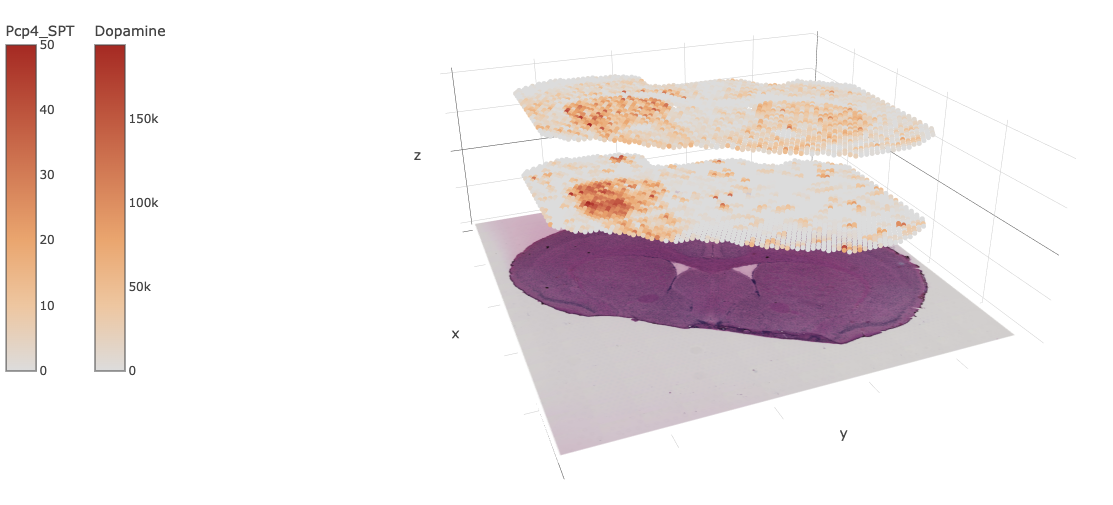](https://github.com/BiomedicalMachineLearning/SpaMTP/blob/master/inst/figures/gene_mz_3Dplot.html)

## 7. Multi-Modality Pathway Analysis

TODO: Ty

In [ ]:
p

In [ ]:
plot_html <- htmlwidgets::saveWidget(p, "temp.html", selfcontained = FALSE)
plot_html <- readLines("temp.html", warn = FALSE)
plot_html <- paste(plot_html, collapse = "\n")

# Read the template file
template <- readLines("test_html.html", warn = FALSE)

# Combine the template lines into a single string
template <- paste(template, collapse = "\n")

# Replace placeholder with plot HTML
rendered_html <- gsub("{{ plot }}", plot_html, template, fixed = TRUE)

# Write the rendered HTML to a new file
#output_html_path <- "output.html"
#writeLines(rendered_html, con = output_html_path)

In [ ]:
output_html_path <- "output.html"
writeLines(rendered_html, con = output_html_path)

In [ ]:
sessionInfo()

In [ ]:
combined.data <- readRDS("/QRISdata/Q1851/Andrew_C/Metabolomics/brain_public_combined.RDS")

In [ ]:
head(combined.data)

## Data 2.0

In [ ]:
vis <- Load10X_Spatial("/QRISdata/Q1851/Andrew_C/Metabolomics/Test_data/public_data/smamsi/sma/data/V11L12-038/V11L12-038_B1/output_data/V11L12-038_B1_RNA/outs/")

### load MSI

In [ ]:
msi <- ReadSM_mtx("/QRISdata/Q1851/Andrew_C/Metabolomics/Test_data/public_data/smamsi/sma/data/V11L12-038/V11L12-038_B1/output_data/V11L12-038_B1_MSI/V11L12-038_B1.Visium.DHB.220826_smamsi.csv")

In [ ]:
msi <- subset(msi, subset = nCount_Spatial > 0)

In [ ]:
msi_annotated <- AnnotateSM(msi, HMDB_db)

In [ ]:
msi_annotated

In [ ]:
card <- ConvertSeuratToCardinal(msi_annotated, assay = "Spatial", slot = "counts", feature.metadata = FALSE, verbose = TRUE)

In [ ]:
card_ssc <- spatialShrunkenCentroids(card, method="adaptive",
                                       r=2, s=c(0,5,10,15,20,25), k=10)

In [ ]:
msi_annotated$ssc <- resultData(card_ssc)[[1]]$class

In [ ]:
s <- c(0,5,10,15,20,25)
for (i in 1:6){
    msi_annotated@meta.data[paste0("ssc_",s[i])] <- resultData(card_ssc)[[i]]$class
}

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 10)

ImageDimPlot(msi_annotated, group.by = paste0("ssc_", s), size = 2)

In [ ]:
vis <- NormalizeData(vis)

In [ ]:
vis <- FindVariableFeatures(vis, verbose = FALSE)
vis <- ScaleData(vis, verbose = FALSE)
vis <- RunPCA(vis, npcs = 30, verbose = FALSE)
vis <- FindNeighbors(vis, dims = 1:30, verbose = FALSE)
vis <- RunUMAP(vis, dims = 1:30, verbose = FALSE)
vis <- FindClusters(vis, resolution = 0.5, verbose = FALSE, cluster.name = "seurat_clusters")

In [ ]:
SpatialDimPlot(vis)

In [ ]:
msi_transformed <- AlignSpatialOmics(sm.data = msi_annotated, st.data = vis)

In [ ]:
saveRDS(msi_transformed, "/scratch/user/uqacause/files/project_data_objects/SpaMTP/brain_dhb_transformed.RDS")

### Test mapping

In [ ]:
msi_transformed <- readRDS("/scratch/user/uqacause/files/project_data_objects/SpaMTP/brain_dhb_transformed.RDS")

In [ ]:
# Function to calculate the coordinates of a square given its center and width
get_square_coordinates <- function(center_x, center_y, width, name) {
  # Calculate half width
  half_width <- width / 2
  
  # Calculate coordinates of the four corners
  x_coords <- c(center_x - half_width, center_x + half_width, center_x + half_width, center_x - half_width, center_x - half_width)
  y_coords <- c(center_y - half_width, center_y - half_width, center_y + half_width, center_y + half_width, center_y - half_width)
  
  # Return the coordinates as a matrix
  square_df <- data.frame(
    Selection = rep(name, n = 4),
    X = x_coords,
    Y = y_coords
    
  )
  return(square_df)
}

AlignXenium <- function(SM.data, ST.data, fov = "fov", annotations = TRUE, overlap.threshold = 0.2, SM.assay = "Spatial", ST.assay = "Spatial", map.data = FALSE, new_SPT.assay = "SPT", new_SPM.assay = "SPM", add.metadata = TRUE,  merge.unique.metadata = TRUE, verbose = FALSE){

    sample_data <- ST.data
    
    ## make polygons from coordinates
    df <- GetTissueCoordinates(SM.data)

    diff_x <- diff(df$x)
    diff_y <- diff(df$y)
    
    # Combine the x and y differences into a data frame
    differences <- data.frame(diff_x, diff_y)
    
    # Filter out cases where the difference is zero
    non_zero_differences <- differences[differences$diff_x != 0 | differences$diff_y != 0,]
    
    # Choose the non-zero difference (maximum absolute value)
    new_widths <- apply(non_zero_differences, 1, function(row) max(abs(row)))
    
    median(new_widths)

    
    polygon_list <- lapply(1:nrow(GetTissueCoordinates(SM.data)), function(idx) {
      row <- df[idx,]
      get_square_coordinates(center_x = row$x, center_y = row$y, width = median(new_widths), name = row$cell)
    })

    # Combine the list of data frames into a single data frame
    polygons_df <- do.call(rbind, polygon_list)
    polygons <- CreateSegmentation(polygons_df)

    sample_data[[fov]][["annotation"]] <- polygons
    pol <- GetTissueCoordinates(sample_data[[fov]][["annotation"]])
    

        ###Make list of polygons from annotations
    active_polygons <- SpatialPolygons(lapply(unique(pol$cell), function(cell_name) {
        cell_data <- pol[pol$cell == cell_name, ]
        Polygons(list(Polygon(cbind(cell_data$x, cell_data$y))), cell_name)}),
                                       1:length(unique(pol$cell)))
    
    empty_poly_df = data.frame(cell = unique(pol$cell))
    rownames(empty_poly_df) <- empty_poly_df$cell
    
    
    df_cells_spdf <- SpatialPolygonsDataFrame(active_polygons, empty_poly_df)

    polygon_df <- sf::st_as_sf(df_cells_spdf)
    
    ## Find Cells within each polygon
    st_coordinates <- GetTissueCoordinates(sample_data[[fov]][["centroids"]])
    st_coordinates$radius = sample_data[[fov]][["centroids"]]@radius * 0.5 #### 10X scalefactors_json.json file states @radius is actually = spot diameter
    points_sf <- sf::st_as_sf(st_coordinates, coords = c("x", "y"))
    points_sf <- sf::st_buffer(points_sf, dist = st_coordinates$radius)
    
        # Find intersecting polygons
    buffer_areas <- sf::st_area(points_sf)

    
    ## Plot polygons
    #plot(polygon_df$geometry, col = "lightblue", border = "black", axes = TRUE)
    #plot(points_sf$geometry,col = "lightblue", border = "black", add = TRUE)

                        
    # Find intersecting polygons
    intersections <- sf::st_intersects(points_sf, polygon_df, sparse = FALSE)
    
    # Create a data frame with results
    
    result <- do.call(rbind, lapply(seq_len(nrow(points_sf)), function(i) {
      # Get the geometry of the buffered point
      point_geom <- points_sf$geometry[i]
      point_area <- buffer_areas[i]
      
      # Find polygons intersecting with the point
      intersecting_polygons <- polygon_df[intersections[i, ], ]
      
      # Calculate intersection areas
      intersection_areas <- sf::st_area(sf::st_intersection(point_geom, intersecting_polygons$geometry))
      
      # Calculate percentage of coverage
      coverage_percentage <- as.numeric(intersection_areas / point_area)
      
      # Filter polygons by coverage percentage
      valid_polygons <- intersecting_polygons$cell[coverage_percentage >= overlap.threshold]
      
      data.frame(
        point = st_coordinates$cell[i],
        polygons = paste(valid_polygons, collapse = ", ")
      )
    }))

    SpaMTP.obj <- AddMetaData(ST.data, result$polygons,"SPM_pixels")
    
    # remove cells with no SM data
    cells_with_na <- rownames(SpaMTP.obj@meta.data)[is.na(SpaMTP.obj@meta.data$SPM_pixels)]

    # Subset the Seurat object based on cells with NA values
    SpaMTP.obj <- subset(SpaMTP.obj, cells = cells_with_na, invert = TRUE)



    mean_counts <- function(spm_pixels, count_matrix) {
      # Split SPM_pixels into individual pixel strings
      pixels <- strsplit(spm_pixels, ",\\s*")[[1]]
      
      if (length(pixels) > 1){
          row_means <- rowMeans(count_matrix[,pixels]) # Compute mean for each feature
      } else if (length(pixels) == 1){
          row_means <- count_matrix[,pixels]
      } else {
          row_means <- rep(0, length(rownames(count_matrix)))
      }
      return(row_means)
    }

    if (map.data) {
        if ("data" %in% Layers(SM.data, assay = SM.assay)){
            mean_count_list <- lapply(SpaMTP.obj$SPM_pixels, mean_counts, count_matrix = SM.data[[SM.assay]]["counts"])
            mean_counts_df <- do.call(rbind, mean_count_list)
            
            mean_data_list <- lapply(SpaMTP.obj$SPM_pixels, mean_counts, count_matrix = SM.data[[SM.assay]]["data"])
            mean_data_df <- do.call(rbind, mean_count_list)
            SpaMTP.obj[["SPM"]] <- CreateAssay5Object(counts = Matrix::t(mean_counts_df), data = Matrix::t(mean_data_df))
            
        } else {
            stop("data slot not present in SPM seurat object provided! Please run NormaliseSMData() or set map.data = FALSE")  
        }
    } else {
        # Apply the function to each row in the reference data frame
        mean_count_list <- lapply(SpaMTP.obj$SPM_pixels, mean_counts, count_matrix = SM.data[[SM.assay]]["counts"])
        mean_counts_df <- do.call(rbind, mean_count_list)
        SpaMTP.obj[[new_SPM.assay]] <- CreateAssay5Object(counts = Matrix::t(mean_counts_df))
    }


    #add metadata from SM

    add_metadata <- function(spm_pixels, SM_metadata) {
      # Split SPM_pixels into individual pixel strings
      pixels <- strsplit(spm_pixels, ",\\s*")[[1]]
      
      if (length(pixels) == 0){
          
          col_names <- colnames(SM_metadata)
          combined_df <- as.data.frame(matrix(NA, nrow = 1, ncol = length(col_names)))
          colnames(combined_df) <- paste0(new_SPM.assay,"_",col_names)
      
      } else {
            sub.metadata <- SM_metadata[pixels,]
            # Apply the function to each column
            if (merge.unique.metadata){
                
                combined_row <- sapply(sub.metadata, function(x){
                    paste(unique(x), collapse = ", ")
                })
            } else {
                combined_row <- sapply(sub.metadata, function(x){
                    paste(unique(x), collapse = ", ")
                })
            }
            
            # Convert to data frame
            combined_df <- as.data.frame(t(combined_row), stringsAsFactors = FALSE)
            colnames(combined_df) <- paste0(new_SPM.assay,"_",colnames(sub.metadata))
          
      }
      return(combined_df)
    }

                        
    if (add.metadata) {
        metadata_list <- lapply(SpaMTP.obj$SPM_pixels, add_metadata, SM_metadata = SM.data@meta.data)
        metadata_df <- do.call(rbind, metadata_list)
        SpaMTP.obj@meta.data[colnames(metadata_df)] <- metadata_df[colnames(metadata_df)]
    }

    

    if (annotations) {
        ## adds m/z annotations to new object
        SpaMTP.obj[[new_SPM.assay]]@meta.data <- SM.data[[SM.assay]]@meta.data
    }

    SpaMTP.obj <- RenameAssays(SpaMTP.obj, assay.name = ST.assay, new.assay.name = new_SPT.assay)

    
    return(SpaMTP.obj)
    
}



In [ ]:
aligned <- AlignXenium(SM.data = msi_transformed, ST.data = vis, fov = "slice1")

In [ ]:
SpatialFeaturePlot(aligned, features = "mz-310.994", slot = "counts")

In [ ]:
saveRDS(aligned, "/scratch/user/uqacause/files/project_data_objects/SpaMTP/aligned_DHB.RDS")

In [ ]:
spata_object2 <-
 asSPATA2(
   object = aligned,
   sample_name = "SeuratProject",
   platform = "VisiumSmall",
   img_name = "slice1",
   img_scale_fct = "lowres",
   assay_name = "SPM",
   assay_modality = "metabolite"
   )



In [ ]:
spata_object2

In [ ]:
plotSurface(spata_object2, pt_alpha = 0)

In [ ]:
spata_object2@meta_obs